# Bar Learning problem

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/BarLearning.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/BarLearning.ipynb)

The bar learning problem describes the process of learning receptive fields on an artificial input pattern.
Images consisting of independent bars are used. Those images are generated as following: an 8\*8 image can filled randomly by eight horizontal or vertical bars, with a probability of 1/8 for each.

These input images are fed into a neural population, whose neurons should learn to extract the independent components of the input distribution, namely single horizontal or vertical bars.


In [1]:
#!pip install ANNarchy

## Model overview

The model consists of two populations `inp` and `pop`. The size of `inp` should be chosen to fit the input image size (here 8*8). The number of neurons in the `pop` population should be higher than the total number of independent bars (16, we choose here 32 neurons). The `pop` population gets excitory connections from `inp` through an all-to-all connection pattern. The same pattern is used for the inhibitory connections within `pop`.

## Defining the neurons and populations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 5.0 (5.0.0) on darwin (posix).


In [3]:
net = ann.Network()

**Input population:**

The input pattern will be clamped into this population by the main loop for every trial, so we just need an `InputArray` to store the values:

In [4]:
N = 8
inp = net.create(ann.InputArray(geometry=(N, N)))

**Learning population:**

The neuron type composing this population sums up all the excitory inputs gain from `inp` and the lateral inhibition within `pop`.

$$\tau \frac {dr_{j}}{dt} + r_{j} = \sum_{i} w_{ij} \cdot r_{i}^{\text{inp}}  - \sum_{k, k \ne j} w_{kj} * r_{k}$$

could be implemented as the following:


In [5]:
LeakyNeuron = ann.Neuron(
    parameters = dict(tau = 10.0),
    equations = ann.Variable("tau * dr/dt + r = sum(exc) - sum(inh)", min=0.0),
)

The firing rate is restricted to positive values with the `min=0.0` attribute. The population of 32 neurons is created in the following way:

In [6]:
pop = net.create(geometry=(N, int(N/2)), neuron=LeakyNeuron)

We define the population with a (8, 4) geometry for visualization only, its 2D structure does not influence computations at all. We could also use `geometry=32` and reshape the array afterwards.

## Defining the synapse and projections

Both feedforward (`inp` $\rightarrow$ `pop`) and lateral (`pop` $\rightarrow$ `pop`) projections are learned using the Oja learning rule (a regularized Hebbian learning rule ensuring the sum of all weights coming to a neuron is constant). Only some parameters will differ between the projections.

$$\tau \frac{dw_{ij}}{dt} = r_{i} \cdot r_{j} - \alpha \cdot r_{j}^{2} \cdot w_{ij}$$

where $\alpha$ is a parameter defining the strength of the regularization, $r_i$ is the pre-synaptic firing rate and $r_j$ the post-synaptic one. The implementation of this synapse type is straightforward:

In [7]:
Oja = ann.Synapse(
    parameters = dict( 
        tau = 2000.0,
        alpha = 8.0,
        min_w = 0.0,
    ),
    equations = ann.Variable(
        "tau * dw/dt = pre.r * post.r - alpha * post.r^2 * w", 
        min='min_w'
    )
)  

For this network we need to create two projections, one excitory between the populations `inp` and `pop` and one inhibitory within the `pop` population itself:

In [8]:
ff = net.connect(
    pre=inp, 
    post=pop, 
    target='exc', 
    synapse = Oja    
)
ff.all_to_all(
    weights = ann.Uniform(0.0, 0.5)
)
                     
lat = net.connect(
    pre=pop, 
    post=pop, 
    target='inh', 
    synapse = Oja
)
lat.all_to_all(
    weights = ann.Uniform(0.0, 1.0)
)

The two projections are all-to-all and use the `Oja` synapse type. They only differ by the parameter `alpha` (lower in `pop`):

In [9]:
lat.alpha = 0.3

We can now compile the network:

In [10]:
net.compile()

Compiling network 1...  OK 


## Setting inputs

Once the network is defined, one has to specify how inputs are fed into
the `inp` population. A simple solution is to define a method that
sets the firing rate of `inp` according to the specified probabilities
every time it is called, and runs the simulation for 50 ms:

In [11]:
def trial():

    # Reset the firing rate for all neurons
    inp.r = 0.0

    # Clamp horizontal bars randomly
    hbars = np.random.binomial(n=1, p=1./N, size=N) == 1
    for i, exists in enumerate(hbars): 
        inp[i, :].r = 1.0 if exists else inp[i, :].r

    # Clamp vertical bars randomly
    vbars = np.random.binomial(n=1, p=1./N, size=N) == 1
    for j, exists in enumerate(vbars): 
        inp[:, j].r = 1.0 if exists else inp[:, j].r

    # Simulate for 50ms
    net.simulate(50.)
    
    # Return firing rates and receptive fields for visualization
    return inp.r, pop.r, ff.receptive_fields()

One can use here a single value or a Numpy array (e.g. `np.zeros(inp.geometry))`) to reset activity in `inp`, it does not matter.

For the random bars, we use the binomial distribution to decide for the existence of a vertical or horizontal bar with a probability of 1/8. 

`inp[i, :]` and `inp[:, j]` are `PopulationViews`, i.e. groups of neurons defined by the sub-indices (here the rows and columns of `inp`). Their attributes, such as `r`, can be accessed and modified as if it were a regular population.

## Running the simulation

Let's have a look at the activities and receptive fields after one trial:

In [12]:
input_array, activity_array, weights = trial()

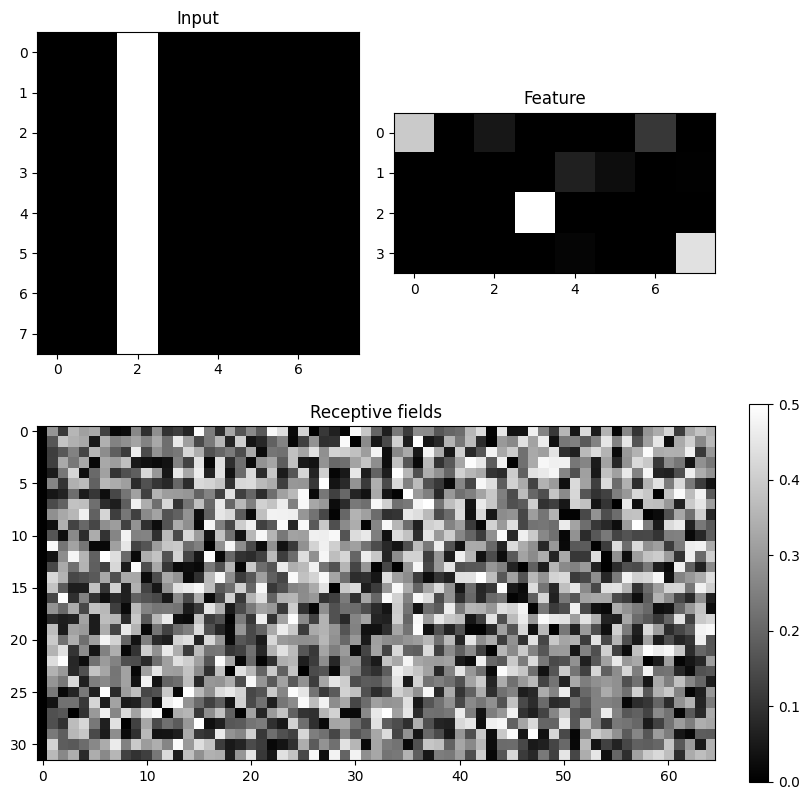

In [13]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained", figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, :]) 

im1 = ax1.imshow(input_array.T, interpolation='nearest', cmap=plt.cm.gray)
ax1.set_title('Input')
im2 = ax2.imshow(activity_array.T, interpolation='nearest', cmap=plt.cm.gray)
ax2.set_title('Feature')
im3 = ax3.imshow(weights.T, interpolation='nearest', cmap=plt.cm.gray, vmin=0.0, vmax=0.5)
ax3.set_title('Receptive fields')
fig.colorbar(im3)

One or a few bars are present in `inp`, a few neurons react in `pop`, but the receptive fields are all random. 

Let's now define a `for` loop where the `trial()` method is called repetitively 10000 times:

In [14]:
inputs = []; features = []; rfs = []

T = 10000
for t in range(T):
    
    # Single trial
    input_r, feature_r, weights = trial()

    # Record every 10 trials
    if t % 10 == 0:
        inputs.append(input_r)
        features.append(feature_r)
        rfs.append(weights)

We can now visualize the activities and receptive fields after learning:

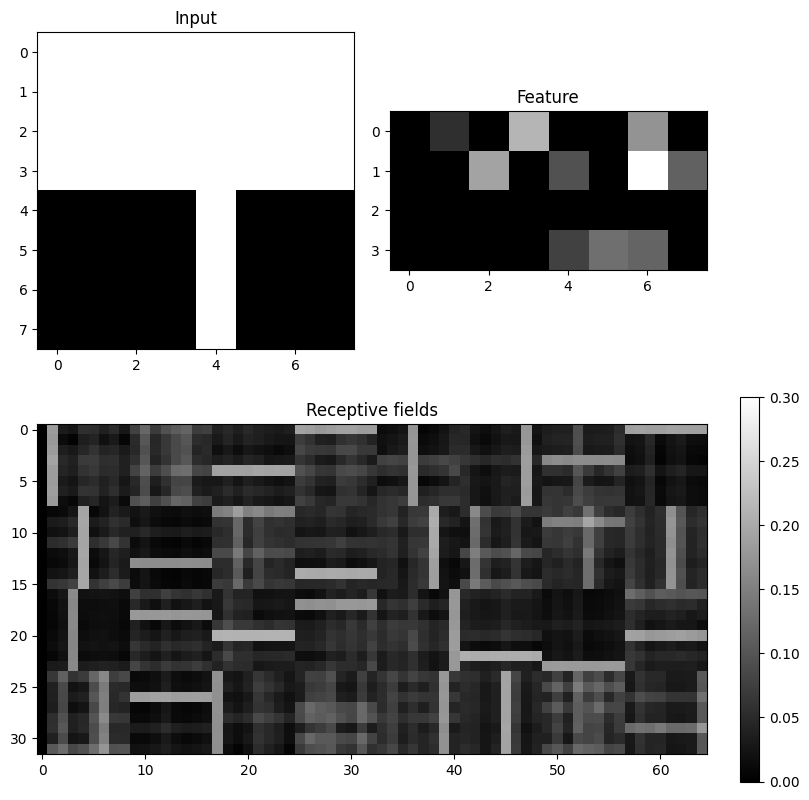

In [15]:
fig = plt.figure(layout="constrained", figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, :]) 

im1 = ax1.imshow(inputs[-1].T, interpolation='nearest', cmap=plt.cm.gray)
ax1.set_title('Input')
im2 = ax2.imshow(features[-1].T, interpolation='nearest', cmap=plt.cm.gray)
ax2.set_title('Feature')
im3 = ax3.imshow(rfs[-1].T, interpolation='nearest', cmap=plt.cm.gray, vmin=0.0, vmax=0.3)
ax3.set_title('Receptive fields')
fig.colorbar(im3)

After 10000 trials, most neurons have developed a receptive field specific for a single horizontal or vertical bar, although these were always presented together.

Let's now have a look at how these receptive fields develop over the course of training.

In [16]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(layout="constrained", figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, :]) 

im1 = ax1.imshow(inputs[-1].T, interpolation='nearest', cmap=plt.cm.gray)
ax1.set_title('Input')
im2 = ax2.imshow(features[-1].T, interpolation='nearest', cmap=plt.cm.gray)
ax2.set_title('Feature')
im3 = ax3.imshow(rfs[-1].T, interpolation='nearest', cmap=plt.cm.gray, vmin=0.0, vmax=0.3)
ax3.set_title('Receptive fields')
cb = fig.colorbar(im3)

def drawframe(n):
    im1.set_data(inputs[n].T)
    im2.set_data(features[n].T) 
    im3.set_data(rfs[n].T) 
    return (im1, im2, im3)

anim = animation.FuncAnimation(fig, drawframe, frames=int(T/10), interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Most neurons become selective for a single bar. However, due to the lateral inhibition, two neurons selective for the same bar will compete with each other. The "losing" neuron will have to modify its receptive field to let the winner have it. This explains the instability of some cells during learning. 